# Large Scale Single Cell Electrophysiology & Behavior

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# This will ensure that the AllenSDK is installed.
# If not, it will install it for you.
try:
    import allensdk
    print('allensdk already installed.')
except ImportError as e:
    !pip install allensdk

allensdk already installed.


In [2]:
# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api import EcephysProjectWarehouseApi
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine

# Import 2-Photon Cache
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

# Assign where neuropixels data and 2-photon data will be stored
manifest_path = 'manifest.json' 
manifest_path2 = 'manifest2.json'

# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest=manifest_path,
                            fetch_api=EcephysProjectWarehouseApi(RmaEngine(scheme="http",host="api.brain-map.org",timeout= 50 * 60)))          

# Create an instance of the Brain Observatory cache
boc = BrainObservatoryCache(manifest_file= manifest_path2)

# Download our session data 
session = cache.get_session_data(719161530)
print('Session downloaded.')

Session downloaded.


## Units

Now that we have downloaded the session file, we can begin to explore our session object. The `units` property of our session object returns a dataframe that contains the recorded activity of our individual neurons. There are many metrics stored within `units` that can be used in your potential analyses. Some key metrics include:

- **firing rate**: mean spike rate during the entire session
- **presence ratio**: fraction of session when spikes are present
- **ISI violations**: rate of refractory period violations
- **Isolation distances**: distance to nearest cluster in Mihalanobis space
- **d'**: classification accuracy based on LDA
- **SNR**: signal to noise ratio
- **Maximum drift**: Maximum change in spike depth during recording
- **Cumulative drift**: Cumulative change in spike depth during recording

In [3]:
units_df = session.units
units_df.head()

,waveform_duration,cluster_id,peak_channel_id,cumulative_drift,amplitude_cutoff,snr,waveform_recovery_slope,isolation_distance,nn_miss_rate,silhouette_score,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950916730,0.315913,0,850252273,421.99,0.010911,2.408535,-0.072013,115.066739,0.001010,NaN,...,215.0,APN,8369.0,3658.0,6985.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916822,0.233501,7,850252319,294.57,0.000025,3.769478,-0.212549,160.983322,0.000000,0.115187,...,215.0,APN,8288.0,3464.0,7039.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916845,0.192295,9,850252323,270.88,0.023245,3.087942,-0.216281,77.035531,0.002380,0.170339,...,215.0,APN,8281.0,3448.0,7044.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916856,0.233501,10,850252325,219.19,0.011552,2.743504,-0.087931,291.708582,0.047256,0.141643,...,215.0,APN,8277.0,3440.0,7046.0,probeA,See electrode locations,29999.967418,1249.998642,True
950916892,0.343384,13,850252329,558.87,0.029890,2.428990,-0.005812,41.639547,0.000338,0.180152,...,215.0,APN,8270.0,3424.0,7051.0,probeA,See electrode locations,29999.967418,1249.998642,True


Just like we did before in our sessions dataframe, we can return the brain structures that our session's data was recorded from as well as how many neurons were recorded per brain area. 

In [4]:
col = 'ecephys_structure_acronym'

print('Available Brain Structures:')
print(units_df[col].unique())
print('\n Brain Structure Frequency:')
print(units_df[col].value_counts())

Available Brain Structures:
['APN' 'DG' 'CA1' 'VISam' 'TH' 'Eth' 'POL' 'LP' 'VISpm' 'NOT' 'SUB' 'VISp'
 'grey' 'VL' 'CA3' 'VISl' 'PO' 'VPM' 'LGd' 'VISal' 'VISrl']

 Brain Structure Frequency:
APN      176
CA1      108
LGd       71
POL       55
VISp      52
SUB       42
VISl      40
VISam     37
LP        28
VPM       24
grey      19
VISpm     18
NOT       16
CA3       14
DG        14
VISrl     10
TH         9
VISal      9
VL         7
PO         5
Eth        1
Name: ecephys_structure_acronym, dtype: int64


To ensure that the recordings we use in our analysis are all of good quality, we will filter the data according to the signal-to-noise ratio (`snr`) and the `ISI_Violations` of our neurons. Below we will plot the distributions of both.

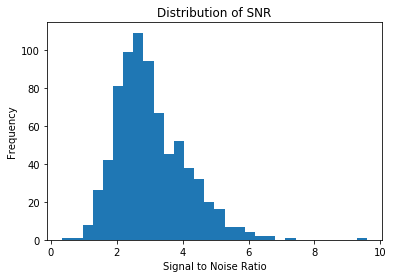

In [5]:
# Signal to noise distribution
col_1 = 'snr'
plt.hist(units_df['snr'], bins=30)
plt.title('Distribution of SNR')
plt.xlabel('Signal to Noise Ratio')
plt.ylabel('Frequency')
plt.show()

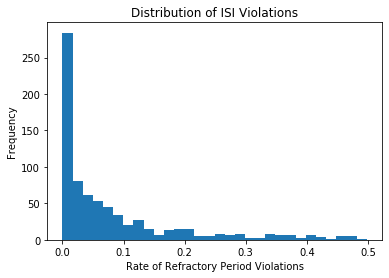

In [6]:
# ISI distribution 
col_2 = 'isi_violations'
plt.hist(units_df[col_2], bins=30)
plt.title('Distribution of ISI Violations')
plt.xlabel('Rate of Refractory Period Violations')
plt.ylabel('Frequency')
plt.show()

For the purposes of this tutorial, we will use `snr` values greater than 1 and `ISI_violation` values less than 0.1, define our quality neurons. 

In [7]:
good_snr = units_df[units_df['snr']>1]
low_isi = units_df[units_df['isi_violations']<0.1]
combined_df = low_isi.merge(good_snr)
print('Number of Recordings with good SNR and Low ISI:')
print(len(combined_df))
combined_df.head()

Number of Recordings with good SNR and Low ISI:
555


,waveform_duration,cluster_id,peak_channel_id,cumulative_drift,amplitude_cutoff,snr,waveform_recovery_slope,isolation_distance,nn_miss_rate,silhouette_score,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
0,0.315913,0,850252273,421.99,0.010911,2.408535,-0.072013,115.066739,0.001010,NaN,...,215.0,APN,8369.0,3658.0,6985.0,probeA,See electrode locations,29999.967418,1249.998642,True
1,0.233501,7,850252319,294.57,0.000025,3.769478,-0.212549,160.983322,0.000000,0.115187,...,215.0,APN,8288.0,3464.0,7039.0,probeA,See electrode locations,29999.967418,1249.998642,True
2,0.233501,10,850252325,219.19,0.011552,2.743504,-0.087931,291.708582,0.047256,0.141643,...,215.0,APN,8277.0,3440.0,7046.0,probeA,See electrode locations,29999.967418,1249.998642,True
3,0.467002,24,850252351,154.34,0.003052,2.084643,-0.059217,179.310426,0.013169,0.102770,...,215.0,APN,8229.0,3331.0,7079.0,probeA,See electrode locations,29999.967418,1249.998642,True
4,0.192295,21,850252349,184.14,0.003787,2.805553,-0.221815,68.033790,0.003977,0.054381,...,215.0,APN,8232.0,3339.0,7077.0,probeA,See electrode locations,29999.967418,1249.998642,True


## Firing Rate

*Explaining Firing Rate*

In [8]:
import seaborn as sns

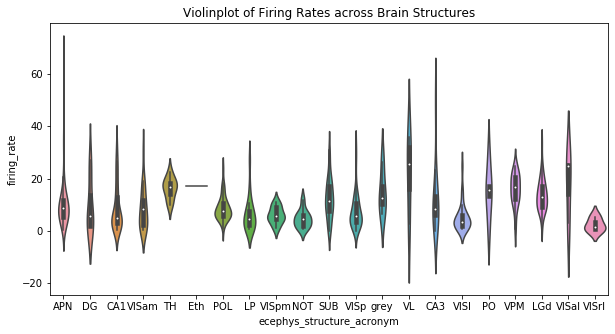

In [9]:
plt.figure(figsize = (10,5))
sns.violinplot(y='firing_rate', x='ecephys_structure_acronym',data = combined_df)
plt.title('Violinplot of Firing Rates across Brain Structures')
plt.show()

## Running Speed 

*explain run speed and 2 photon/neuropixels connectivity*

In [10]:
rs = session.running_speed
rs.head()

,start_time,end_time,velocity
0,29.77937,29.79390,-0.375017
1,29.79390,29.81039,3.825516
2,29.82680,29.84451,-0.942946
3,29.84451,29.85961,-1.594519
4,29.87652,29.89318,1.059689


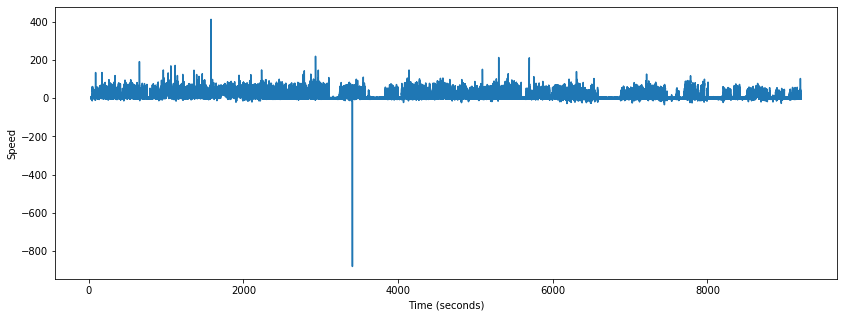

In [11]:
y = rs['velocity']
x = rs['start_time']

# Plot it
plt.figure(figsize=(14,5))
plt.plot(x,y)
plt.xlabel('Time (seconds)')
plt.ylabel('Speed')
plt.show()

In [12]:
# Assign previous container ID
exp_container_id = 627823571
stim = ['drifting_gratings']

# Get experiments for our container id and stimuli of interest
experiments = boc.get_ophys_experiments(experiment_container_ids = [exp_container_id],
                                     stimuli = stim)

# Assign the experiment id 
experiment_id = experiments[0]['id']
experiment_data = boc.get_ophys_experiment_data(experiment_id)

# Assign timestamps and deltaF/F
ts, dff = experiment_data.get_dff_traces()
dff_mean =np.mean(dff, axis = 0)
dff_mean.shape

print('Data acquired.')

Data acquired.


In [13]:
bin_size = 5 
bin_stamps = np.arange(0,ts.max(),bin_size)
num_bins = len(bin_stamps)

run_bin = np.empty(num_bins)
response_bin = np.empty(num_bins)

for i in range(num_bins):
    
    # Get the values within our time bin and take a mean
    run_bin[i] = y[np.where([(ts>i*bin_size), (ts<(i+1)*bin_size)].mean() 
    response_bin[i] = dff_mean[np.where([(ts>i*bin_size), (ts<(i+1)*bin_size)].mean()

SyntaxError: invalid syntax (<ipython-input-13-1ef7f4665be5>, line 12)